In [1]:
%pylab inline
import boto3
import uuid
import base64
import cPickle as pickle
import seaborn as sns
sns.set_style('whitegrid')
import os

Populating the interactive namespace from numpy and matplotlib


In [2]:
AWS_S3_BUCKET = "jonas-testbucket2"
AWS_S3_PREFIX = "pywren.jobs"
#callset_id = '4aaff499-721f-42a4-85d8-434827c55b39'
#callset_id = '0b193421-83ed-4fe5-bfca-418ba9597517'
#callset_id = '59365c44-abdf-4e2f-8aa2-3dcae519a204'
callset_id = '5e52181b-6258-4eca-8780-faa0ba3b9eac'
s3 = boto3.resource('s3', region_name='us-west-2')
b = s3.Bucket(AWS_S3_BUCKET)
prefix = os.path.join(AWS_S3_PREFIX, callset_id)
print prefix
status_keys = []
continuation_token = None

s3res = s3.meta.client.list_objects_v2(Bucket=AWS_S3_BUCKET, Prefix=prefix, MaxKeys=1000)
    
while True:
    for k in s3res['Contents']:
        if "status.json" in k['Key']:
            status_keys.append(k['Key'])

    if 'NextContinuationToken' in s3res:
        continuation_token = s3res['NextContinuationToken']
        s3res = s3.meta.client.list_objects_v2(Bucket=AWS_S3_BUCKET, Prefix=prefix, MaxKeys=1000, 
                                              ContinuationToken = continuation_token)
    else:
        break
print len(status_keys)

pywren.jobs/5e52181b-6258-4eca-8780-faa0ba3b9eac
1600


In [3]:
import json
results = []
for sk in status_keys:
    a = s3.meta.client.get_object(Bucket=AWS_S3_BUCKET, Key=sk)
    b = a["Body"].read()
    results.append(json.loads(b))

In [4]:
start_times = np.array([r['start_time'] for r in results])
host_submit_times = np.array([r['host_submit_time'] for r in results])
end_times = np.array([r['end_time'] for r in results])
setup_times = np.array([r['setup_time'] for r in results])
exec_times = np.array([r['exec_time'] for r in results])
call_ids = np.array([int(r['call_id']) for r in results])

min_start_time = np.min(host_submit_times)
start_times -= min_start_time
end_times -= min_start_time
host_submit_times -= min_start_time

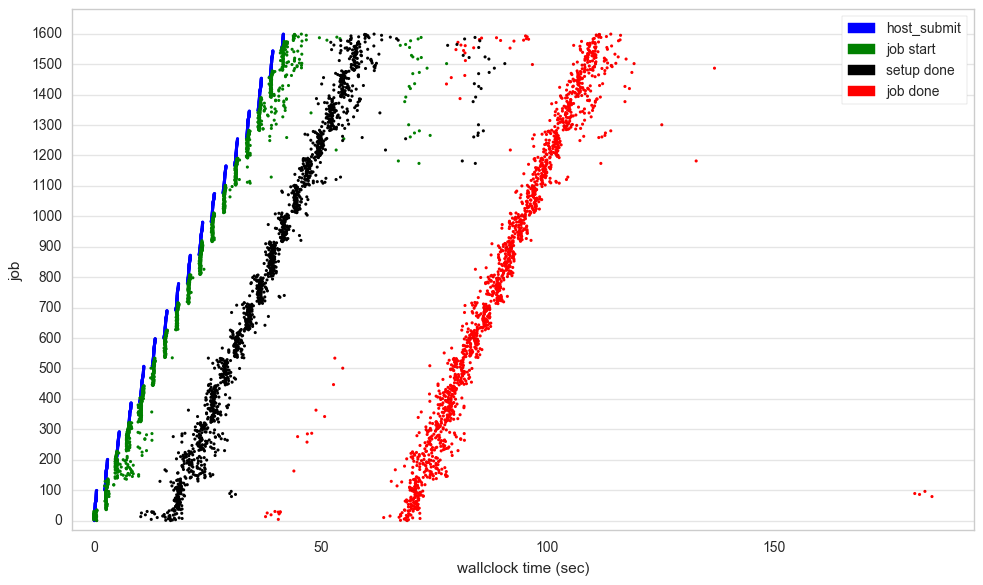

In [18]:
fig = pylab.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
i = np.argsort(call_ids)
y = np.arange(len(start_times))
point_size = 5
ax.scatter(host_submit_times[i], y, c='b', edgecolor='none', s=point_size)
ax.scatter(start_times[i], y, c='g', edgecolor='none', s=point_size)
ax.scatter(end_times[i], y, c='r', edgecolor='none', s=point_size)
ax.scatter((start_times + setup_times)[i], y, c='k', edgecolor='none', s=point_size)
ax.set_xlabel('wallclock time (sec)')
ax.set_ylabel('job')
#pylab.ylim(0, 10)

import matplotlib.patches as mpatches

host_submit_patch = mpatches.Patch(color='b', label='host_submit')
job_start_patch = mpatches.Patch(color='g', label='job start')
setup_done_patch = mpatches.Patch(color='k', label='setup done')

job_done_patch = mpatches.Patch(color='red', label='job done')

legend = pylab.legend(handles=[host_submit_patch, job_start_patch, setup_done_patch, job_done_patch, ],
                      loc='upper right', frameon=True)
#pylab.title("Runtime for 3000 jobs of 1100M double ops (dgemm) each")
legend.get_frame().set_facecolor('#FFFFFF')


total_jobs = len(host_submit_times)
plot_step = 100  #int(np.min([128, total_jobs/32]))
y_ticks = np.arange(len(host_submit_times)//plot_step + 2) * plot_step
ax.set_yticks(y_ticks)
ax.set_ylim(-0.02*len(host_submit_times), len(host_submit_times)*1.05)

ax.set_xlim(-5, np.max(end_times)*1.05)
for y in y_ticks:
    ax.axhline(y, c='k', alpha=0.1, linewidth=1)
 
ax.grid(False)
fig.tight_layout()
fig.savefig("pywren.jobs.png")

In [6]:
test_index = np.arange(len(end_times))
t = np.sort(end_times)
JOB_GFLOPS = 2 * 4096**3  *6 /1e9

In [7]:
# now compute peak 
runtime_bins = np.linspace(0, 220, 220)
runtime_flops_hist = np.zeros((len(end_times), len(runtime_bins)))
for i in range(len(end_times)):
    s = (start_times + setup_times)[i]
    e = end_times[i]
    a, b = np.searchsorted(runtime_bins, [s, e])
    if b-a > 0:
        runtime_flops_hist[i, a:b] = JOB_GFLOPS / float(b-a)


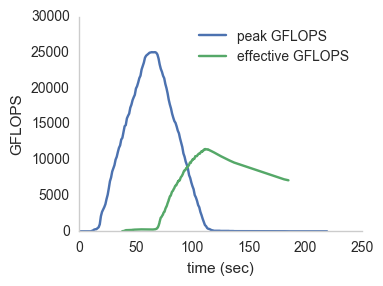

In [21]:
fig = pylab.figure(figsize=(4, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(runtime_flops_hist.sum(axis=0), label='peak GFLOPS')
ax.plot(t, test_index* JOB_GFLOPS/t, label='effective GFLOPS')
ax.set_xlabel('time (sec)')
ax.set_ylabel("GFLOPS")
pylab.legend()
ax.grid(False)
sns.despine()
fig.tight_layout()
fig.savefig("pywren.gflops.png")

In [9]:
# cloudwatch logs
logsclient = boto3.client('logs', region_name='us-west-2')


In [10]:
log_group_name = results[0]['log_group_name']
log_stream_name = results[0]['log_stream_name']
aws_request_id = results[0]['aws_request_id']
events = logsclient.get_log_events(logGroupName=log_group_name, 
                              logStreamName=log_stream_name)

In [11]:
for e in events['events']:
    if 'REPORT' in e['message'] :
        print e['message']

REPORT RequestId: 3ebe4471-986e-11e6-8465-f9f5318dc50a	Duration: 68898.99 ms	Billed Duration: 68900 ms 	Memory Size: 1536 MB	Max Memory Used: 900 MB	



In [12]:
results[0]['end_time'] - results[0]['start_time']

68.52827906608582

In [13]:
all_times = end_times-start_times
price_per_100ms = 0.000002501
costs = all_times * 10.0 * price_per_100ms
print np.sum(costs)

2.67108899589


In [14]:
np.sum(all_times) / 60/ 60.0

29.666899861031109

In [15]:
# parse the logs
loglines = open("/data/jonas/pywren/examples/benchmark.log", 'r').readlines()


In [16]:
[l for l in loglines if "b5498f4e-6087-49c5-ad9d-7421c84a778d 00084" in l]



[]